In [1]:
from phantominator import shepp_logan
from matplotlib import pyplot as plt
import numpy as np

import torch

from loguru import logger
import pathlib
from natsort import natsorted, ns

import pandas as pd

from transformers import AutoModelForCausalLM

import csv

/home/nsagan/experiments/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Notes 01/18
- Hadamard transform during finetuning
- Change the optimization scheme for LoftQ --- try a projected ADMM algorithm (usually does better than just alternating optimization)
- Q + LR + Sparse, optimize via ADMM. Make sparsity a constraint instead of an $\ell_1$ term, with a pre-determined sparsity level

For quant: $$min_{Q \in \mathcal{C}, Q' \in \mathbb{R}^{n\times m}, L, R} \text{<fro norm>} \text{ s.t. } Q'=Q$$

- Use the spectrum to determine which scheme to use

### Notes 01/11
- Preventing Diverging LoftQ optimization w/ "momentum":
$B_{k+1} = Q((1-\alpha) B_k + \alpha * B_k)$
- Question: does NF work or not; convergence issue
- Try sketching
- Can rotate $L$ and $R$ with some unitary matrix $H$ that makes the data more NF-quantizable (more Gaussian)
- Add F-norm regularization on $L$, $R$
- Some normalize and shift
- Sparse $Q$
- Make $Q$ have a Kronecker structure ($\exist$ papers on this)
- Replace $Q$ with $QD$, where $D$ is full-precision and diagonal
- Try changing the objective function (type of norm)?
- Use data-aware oprimization: right-multiply by a batch of training data (see: GPTQ)

In [2]:
%load_ext autoreload
%autoreload 2

In [35]:
from lplr.quantization import *
from lplr.weight_compressors import *
from lplr.hyperparameter_sweeps import *
from lplr.benchmarkers import *
from peft.utils.loftq_utils import loftq_init
from peft.utils.loftq_lplr_utils import loftq_lplr_init
from peft.utils.quantization_utils import NFQuantizerFactory
from lplr.enums import *

In [4]:
DEFAULT_DEVICE = "cuda:2"

In [5]:
mistral = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1")

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


In [190]:
layer_name, X_mis = list(mistral.named_parameters())[10]
X_mis = X_mis.detach().to(DEFAULT_DEVICE)
print(X_mis.shape)

torch.Size([4096, 4096])


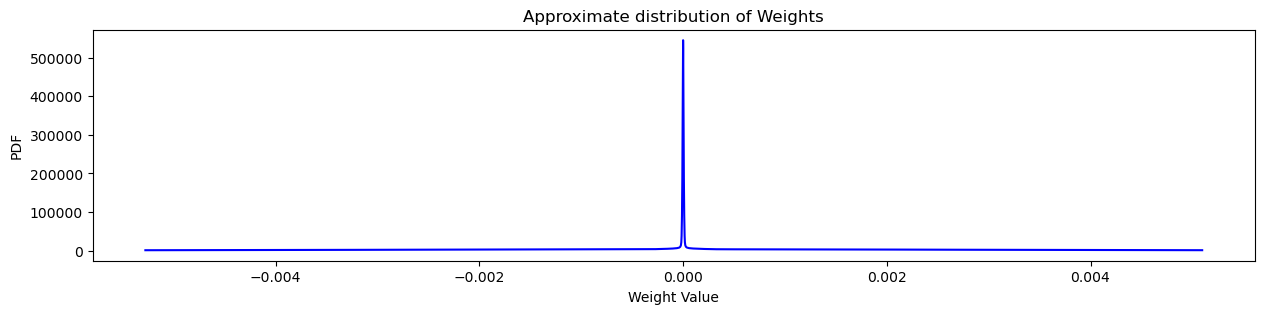

In [191]:
quantiles = np.quantile(X_mis.flatten().cpu(), np.arange(200)/200)
approx_pdf = 2/(quantiles[20:-10] -quantiles[10:-20])
approx_pdf_idxs = quantiles[15:-15]
plt.figure(figsize=(15, 3))
plt.title("Approximate distribution of Weights")
plt.xlabel("Weight Value")
plt.ylabel("PDF")
plt.plot(approx_pdf_idxs, approx_pdf, color="blue")

torch.Size([1024, 4096])


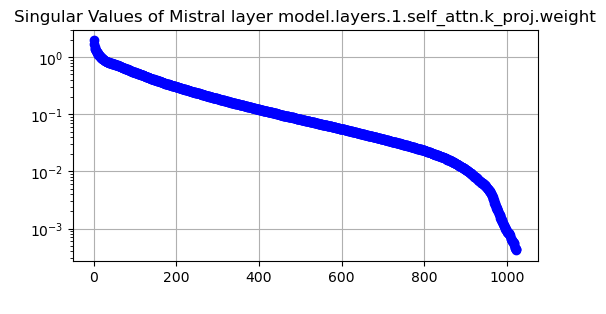

In [174]:
print(X_mis.shape)
_, S, _ = torch.linalg.svd(X_mis.float(), full_matrices=False)

# Plot the singular values
plt.figure(figsize=(6, 3))
plt.plot(S.cpu(), marker='o', linestyle='-', color='b')
plt.title(f'Singular Values of Mistral layer {layer_name}')
plt.xlabel('Index', color="white")
plt.ylabel('Singular Value', color="white")
plt.yscale('log')
plt.grid(True)
plt.show()

In [42]:
# Generate a phantominator matrix
# X = torch.Tensor(shepp_logan(2048))
# plt.imshow(X, cmap="gray", interpolation="nearest")
# plt.show()
# _, S, _ = torch.linalg.svd(X.float(), full_matrices=False)

# # Plot the singular values
# plt.figure(figsize=(11, 3))
# plt.plot(S, marker='o', linestyle='-', color='b')
# plt.title('Singular Values of Phantom(1024)')
# plt.xlabel('Index', color="white")
# plt.ylabel('Singular Value', color="white")
# plt.yscale('log')
# plt.grid(True)
# plt.show()

In [168]:
def test_iterative_weight_compression(
    X = None,
    weight_comp_configs: list[WeightCompressionConfig]=[
        WeightCompressionConfig(
            algorithm_type=AlgorithmType.ALTERNATING_MIXED_LPLR,
            algorithm_kwargs={
                "k": 64, "r1": 0, "r2": 0,
                "B1": 8, "B2": 8
            }
        )
    ],
    plot_title = "Frobenius Norm Errors over Iterations",
    seed=42
):
    plot_colors = ["b", "r", "g", "c", "m", "k"]
    plot_markers = ["o", "X", "*"]
    # Set random seed for reproducibility
    torch.manual_seed(seed)

    plt.figure(figsize=(11, 3))
    for i, config in enumerate(weight_comp_configs):
        kwargs = config.algorithm_kwargs.copy()
        algorithm_type = config.algorithm_type
        kwargs["log_errors"] = True

        if config.hadamard:
            result = hadamard_weight_compression(
                X=X, config=WeightCompressionConfig(
                    algorithm_type=config.algorithm_type,
                    algorithm_kwargs=kwargs
                )
            )
            errors = result[-1]
        elif algorithm_type == AlgorithmType.ALTERNATING_MIXED_LPLR:
            kwargs["X"] = X
            _, _, errors = alternating_mixed_lplr(**kwargs)
        elif algorithm_type == AlgorithmType.DIRECT_SVD_LPLR:
            kwargs["X"] = X
            _, _, errors = direct_svd_mixed_lplr(**kwargs)
        elif algorithm_type == AlgorithmType.LOFTQ:
            kwargs["weight"] = X
            _, _, _, errors = loftq_init(**kwargs)
        else: ## Loftq-LPLR
            kwargs["weight"] = X
            _, _, _, errors = loftq_lplr_init(**kwargs)

        fro_norm_X = torch.norm(X, p="fro").item()
        relative_errors = np.array(errors) / fro_norm_X

        print(relative_errors)

        # Plot errors over iterations
        plt.plot(
            range(1, len(relative_errors) + 1),
            relative_errors,
            marker=plot_markers[(i // len(plot_colors)) % len(plot_markers)],
            linestyle="-",
            markersize=4,
            color=plot_colors[i % len(plot_colors)],
            label=f"Param Set {i+1}*")

    print("-"*80, "\n* Legend Key")
    for i, config in enumerate(weight_comp_configs):
        print(f"Param Set {i+1}: ", config.algorithm_kwargs)
        print("\tusing algorithm type ", config.algorithm_type)
        if config.hadamard:
            print("\twith randomized Hadamard transform")

    plt.title(plot_title)
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.show()

[0.08810391 0.08407702 0.08195148 0.08057621 0.07961584 0.07891554
 0.07836088 0.07790461 0.07752088 0.07720148 0.07693864 0.07670522
 0.07649555 0.07632012 0.07616781 0.07603426 0.07590967 0.0757979
 0.07569424 0.0755986  0.0755152  0.07543742 0.07536568 0.07529927
 0.07523783 0.07518402 0.07513328 0.07508593 0.07504499 0.07500704]
-------------------------------------------------------------------------------- 
* Legend Key
Param Set 1:  {'num_bits': 4, 'reduced_rank': 64, 'num_iter': 30, 'quantizer_factory': <lplr.quantization.QuantizerFactory object at 0x7faaa2bd2190>}
	using algorithm type  AlgorithmType.LOFTQ


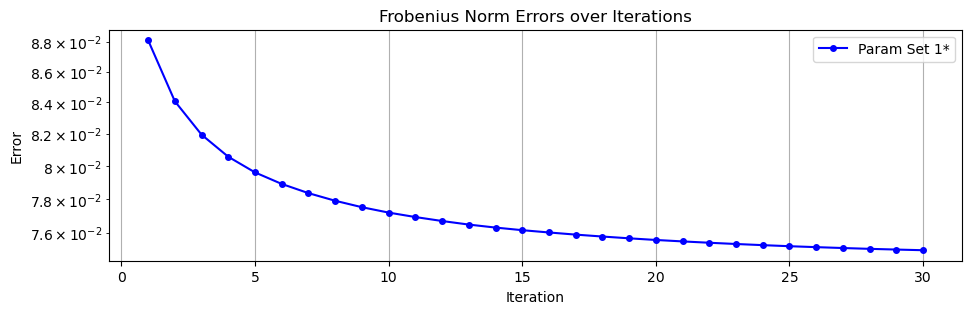

In [173]:
## WITHOUT HADAMARD SKETCH
test_iterative_weight_compression(
    weight_comp_configs=[
        WeightCompressionConfig(
            algorithm_kwargs={
                "num_bits": 4, "reduced_rank": 64, "num_iter": 30, "quantizer_factory": QuantizerFactory("normal")
            },
            algorithm_type=AlgorithmType.LOFTQ,
            hadamard=False
        ),
        # WeightCompressionConfig(
        #     algorithm_kwargs={
        #         "num_bits": 4, "num_bits_factors": 8, "reduced_rank": 64,
        #         "num_iter": 50, "num_iter_lplr": 30, "quantizer_factory": QuantizerFactory("normal")
        #     },
        #     algorithm_type=AlgorithmType.LOFTQ_LPLR,
        #     hadamard=False
        # )
    ],
    plot_title="Frobenius Norm Errors over Iterations",
    X=X_mis.T
)

Final error: 0.07826831191778183
[0.08814627 0.08568557 0.08427254 0.08331527 0.0826128  0.08206445
 0.08162765 0.08126463 0.08095924 0.08070069 0.0804797  0.08028746
 0.08011955 0.07997133 0.07983997 0.07972187 0.07961098 0.07950962
 0.07941971 0.07933606 0.0792598  0.07919078 0.0791269  0.07906459
 0.07900838 0.07895348 0.07890484 0.07885591 0.07881012 0.07876761
 0.07872788 0.07869188 0.0786543  0.07862217 0.07859077 0.07856114
 0.07853257 0.07850585 0.07848157 0.07845717 0.07843526 0.0784141
 0.07839366 0.07837486 0.0783545  0.07833697 0.07831728 0.07829817
 0.078284   0.07826831]
-------------------------------------------------------------------------------- 
* Legend Key
Param Set 1:  {'num_bits': 4, 'reduced_rank': 64, 'num_iter': 50, 'quantizer_factory': <lplr.quantization.QuantizerFactory object at 0x7fb32c2c6f50>}
	using algorithm type  AlgorithmType.LOFTQ
	with randomized Hadamard transform


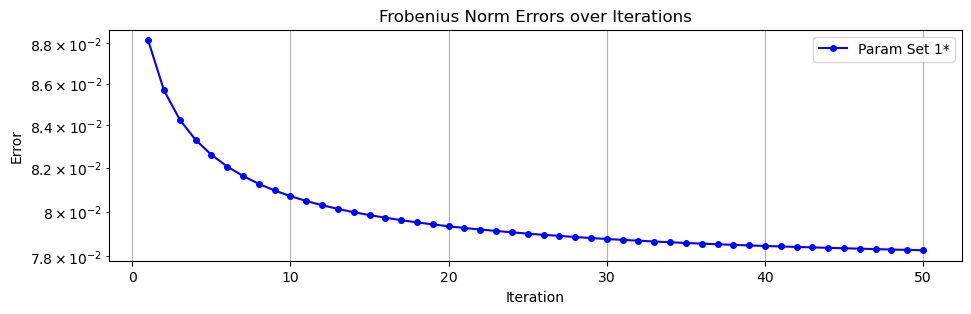

In [70]:
## WITH HADAMARD
test_iterative_weight_compression(
    weight_comp_configs=[
        WeightCompressionConfig(
            algorithm_kwargs={
                "num_bits": 4, "reduced_rank": 64, "num_iter": 50, "quantizer_factory": QuantizerFactory("normal")
            },
            algorithm_type=AlgorithmType.LOFTQ,
            hadamard=True
        ),
        # WeightCompressionConfig(
        #     algorithm_kwargs={
        #         "num_bits": 4, "num_bits_factors": 8, "reduced_rank": 64,
        #         "num_iter": 50, "num_iter_lplr": 30, "quantizer_factory": QuantizerFactory("normal")
        #     },
        #     algorithm_type=AlgorithmType.LOFTQ_LPLR,
        #     hadamard=True
        # )
    ],
    plot_title="Frobenius Norm Errors over Iterations",
    X=X_mis.T,
    seed=42
)

Final error: 0.09425748884677887
[0.10998862 0.10786297 0.10655505 0.10565988 0.10499903 0.10448649
 0.10407468 0.10373514 0.10344895 0.10320479 0.1029925  0.102806
 0.10264123 0.10249411 0.10236216 0.10224245 0.10213361 0.10203426
 0.10194365 0.10186006 0.10178263 0.10171091 0.10164382 0.1015809
 0.10152183 0.10146668 0.10141491 0.10136563 0.10131913 0.10127528
 0.10123367 0.10119426 0.10115652 0.10112077 0.10108696 0.10105486
 0.10102414 0.10099448 0.1009661  0.10093924 0.10091329 0.10088859
 0.10086465 0.10084176 0.10081962 0.10079829 0.10077782 0.10075791
 0.1007387  0.10072017]
[0.11434247 0.11254897 0.11144349 0.11062775 0.10997172 0.10941656
 0.10893544 0.10851126 0.1081316  0.10779008 0.10748177 0.10720122
 0.10694519 0.10671028 0.10649305 0.10629267 0.10610638 0.10593316
 0.10577276 0.10562296 0.10548323 0.10535186 0.10522821 0.10511237
 0.10500276 0.10489916 0.10480102 0.10470803 0.1046199  0.10453691
 0.104458   0.10438318 0.10431191 0.10424398 0.10417872 0.10411657
 0.10405

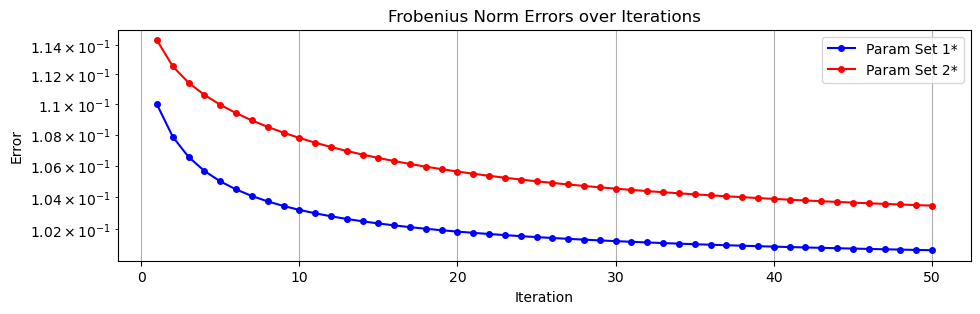

In [17]:
test_iterative_weight_compression(
    weight_comp_configs=[
        WeightCompressionConfig(
            algorithm_kwargs={
                "num_bits": 4, "reduced_rank": 64, "num_iter": 50, "quantizer_factory": QuantizerFactory("uniform_clipped")
            },
            algorithm_type=AlgorithmType.LOFTQ,
            hadamard=True
        ),
        WeightCompressionConfig(
            algorithm_kwargs={
                "num_bits": 4, "reduced_rank": 64, "num_iter": 50, "quantizer_factory": QuantizerFactory("uniform_clipped")
            },
            algorithm_type=AlgorithmType.LOFTQ,
            hadamard=False
        )
    ],
    plot_title="Frobenius Norm Errors over Iterations",
    X=X_mis.T
)

In [29]:
### Do some hyperparameter sweeps on the Shepp-Logan matrix
average_bit_level = 3
budget = X_mis.shape[0] * X_mis.shape[1] * average_bit_level

In [30]:
mtxs, alpha, beta, B, error = lplr_sweep_alpha_and_B(
    X=X_mis.T, budget=budget,
    weight_comp_config=WeightCompressionConfig(
        algorithm_kwargs={"quantizer_factory": NFQuantizerFactory("normal"), "iters":30},
        algorithm_type=AlgorithmType.ALTERNATING_MIXED_LPLR
    ),
    debug=True
)

--------------------------------------------------


2024-01-12 00:20:46.814 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=4, alpha=0.0, beta=0.6
2024-01-12 00:20:47.676 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.06845848878954429


--------------------------------------------------


2024-01-12 00:20:47.677 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=4, alpha=0.1, beta=0.46153846
2024-01-12 00:20:48.291 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.04530449709340094


--------------------------------------------------


2024-01-12 00:20:48.292 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=4, alpha=0.2, beta=0.375
2024-01-12 00:20:48.831 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.05416434301824038


--------------------------------------------------


2024-01-12 00:20:48.832 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=4, alpha=0.3, beta=0.31578947
2024-01-12 00:20:49.320 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.0641400921473226


--------------------------------------------------


2024-01-12 00:20:49.321 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=4, alpha=0.4, beta=0.27272727
2024-01-12 00:20:49.782 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.07341879754234797


--------------------------------------------------


2024-01-12 00:20:49.783 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=4, alpha=0.5, beta=0.24
2024-01-12 00:20:50.221 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.08208555241419419


--------------------------------------------------


2024-01-12 00:20:50.222 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:172 - [B=4]The best frobenius norm error was for alpha=0.1: 0.04530449709340094


--------------------------------------------------


2024-01-12 00:20:50.223 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=8, alpha=0.0, beta=0.3
2024-01-12 00:20:50.717 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.0661925015194805


--------------------------------------------------


2024-01-12 00:20:50.718 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=8, alpha=0.1, beta=0.27272727
2024-01-12 00:20:51.190 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.07246788963039755


--------------------------------------------------


2024-01-12 00:20:51.192 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=8, alpha=0.2, beta=0.25
2024-01-12 00:20:51.641 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.0783647892075003


--------------------------------------------------


2024-01-12 00:20:51.642 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=8, alpha=0.3, beta=0.23076923
2024-01-12 00:20:52.071 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.08398567511041631


--------------------------------------------------


2024-01-12 00:20:52.072 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=8, alpha=0.4, beta=0.21428571
2024-01-12 00:20:52.487 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.08923947061505125


--------------------------------------------------


2024-01-12 00:20:52.488 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=8, alpha=0.5, beta=0.2
2024-01-12 00:20:52.893 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.09432465092041671


--------------------------------------------------


2024-01-12 00:20:52.894 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:172 - [B=8]The best frobenius norm error was for alpha=0.0: 0.0661925015194805


--------------------------------------------------


2024-01-12 00:20:52.895 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha_and_B:243 - The best frobenius norm error was for B=4, alpha=0.1: 0.04530449709340094


In [32]:
mtxs, alpha, beta, B, error = lplr_sweep_alpha_and_B(
    X=X_mis.T, budget=budget,
    weight_comp_config=WeightCompressionConfig(
        algorithm_kwargs={"quantizer_factory": QuantizerFactory("normal"), "num_bits": 2, "num_iter": 20, "num_iter_lplr": 20},
        algorithm_type=AlgorithmType.LOFTQ_LPLR
    ),
    debug=True
)

--------------------------------------------------


2024-01-12 00:22:17.208 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=4, alpha=0.0, beta=0.2


2024-01-12 00:22:23.456 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.3068090931088024


--------------------------------------------------


2024-01-12 00:22:23.456 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=4, alpha=0.1, beta=0.15384615
2024-01-12 00:22:29.048 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.33368878178569544


--------------------------------------------------


2024-01-12 00:22:29.049 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=4, alpha=0.2, beta=0.125
2024-01-12 00:22:34.269 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.35119298588944686


--------------------------------------------------


2024-01-12 00:22:34.270 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=4, alpha=0.3, beta=0.10526316
2024-01-12 00:22:39.321 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.3637852776019634


--------------------------------------------------


2024-01-12 00:22:39.322 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=4, alpha=0.4, beta=0.09090909
2024-01-12 00:22:44.268 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.37255175092157616


--------------------------------------------------


2024-01-12 00:22:44.269 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=4, alpha=0.5, beta=0.08
2024-01-12 00:22:49.107 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.3806278615889524


--------------------------------------------------


2024-01-12 00:22:49.108 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:172 - [B=4]The best frobenius norm error was for alpha=0.0: 0.3068090931088024


--------------------------------------------------


2024-01-12 00:22:49.109 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=8, alpha=0.0, beta=0.1
2024-01-12 00:22:54.165 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.3649026064197117


--------------------------------------------------


2024-01-12 00:22:54.166 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=8, alpha=0.1, beta=0.09090909
2024-01-12 00:22:59.110 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.3707536493267637


--------------------------------------------------


2024-01-12 00:22:59.111 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=8, alpha=0.2, beta=0.08333333
2024-01-12 00:23:03.979 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.3762287366190088


--------------------------------------------------


2024-01-12 00:23:03.980 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=8, alpha=0.3, beta=0.07692308
2024-01-12 00:23:08.802 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.38106460725993646


--------------------------------------------------


2024-01-12 00:23:08.803 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=8, alpha=0.4, beta=0.07142857
2024-01-12 00:23:13.607 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.3847571968220562


--------------------------------------------------


2024-01-12 00:23:13.609 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:143 - B=8, alpha=0.5, beta=0.06666667
2024-01-12 00:23:18.399 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:159 - Frobenius norm error: 0.38841893082535883


--------------------------------------------------


2024-01-12 00:23:18.400 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha:172 - [B=8]The best frobenius norm error was for alpha=0.0: 0.3649026064197117


--------------------------------------------------


2024-01-12 00:23:18.401 | INFO     | hyperparameter_sweeps:lplr_sweep_alpha_and_B:243 - The best frobenius norm error was for B=4, alpha=0.0: 0.3068090931088024


In [33]:
class BenchmarkerComparison():
    def __init__(
        self,
        benchmarkers: list[WeightCompressionBenchmarker] = [],
        enforce_budget = True,
        average_bit_level = 4,
        save_to_csv = False,
        continue_csv = False,
        save_file = None,
        reset_error_lists = True
    ):
        if reset_error_lists:
            for benchmarker in benchmarkers:
                benchmarker.reset_errors()

        self.benchmarkers = benchmarkers
        self.save_to_csv = save_to_csv or continue_csv
        self.continue_csv = continue_csv
        self.save_file = save_file
        self.enforce_budget = enforce_budget
        self.average_bit_level = average_bit_level if enforce_budget else 256
        
        if save_to_csv and not continue_csv:
            with open(save_file, 'w') as csvfile:
                writer = csv.writer(csvfile)

                first_headers = ["Layer Name", "n", "d"]
                if enforce_budget:
                    first_headers.append("Bit Budget")
                writer.writerow(first_headers + [benchmarker.label for benchmarker in benchmarkers])
        if continue_csv:
            df = pd.read_csv(save_file)
            self.prev_layer_names = list(df["Layer Name"])
    
    def write_latest_data(self, layer_name, n, d, budget=0):
        with open(self.save_file, 'a') as csvfile:
            writer = csv.writer(csvfile)
            first_items = [layer_name, n, d]
            if self.enforce_budget:
                first_items.append(budget)
            writer.writerow(first_items + [benchmarker.errors[-1] for benchmarker in self.benchmarkers])
    
    def run_on_matrix(self, layer_name, X):
        if self.continue_csv and layer_name in self.prev_layer_names:
            return
        print(f"Benchmarking {layer_name}")
        n, d = X.size()
        budget = n*d*self.average_bit_level

        for benchmarker in self.benchmarkers:
            benchmarker.run(X, budget)

        if self.save_to_csv:
            self.write_latest_data(layer_name, n, d, budget)

    def print_errors(self):
        for benchmarker in self.benchmarkers:
            print(f"{benchmarker.label}: {benchmarker.errors}")

    def plot_errors(self):
        plot_colors = ["b", "r", "g", "c", "m", "k"]
        plot_markers = ["o", "X", "*"]

        plt.figure(figsize=(15, 4))
        for i, benchmarker in enumerate(self.benchmarkers):
            plt.plot(
                benchmarker.errors,
                marker=plot_markers[(i // len(plot_colors)) % len(plot_markers)],
                linestyle="-",
                markersize=4,
                color=plot_colors[i % len(plot_colors)],
                label=benchmarker.label
            )
        plt.title("Relative Frobenius Error")
        plt.xlabel("Layer")
        plt.ylabel("Error")
        plt.yscale("log")
        plt.grid(True)
        plt.legend()
        plt.show()


In [34]:
class BenchmarkerComparisonList(BenchmarkerComparison):
    def __init__(
        self,
        X_list: list[torch.Tensor] = [],
        **kwargs
    ):
        self.X_list = X_list
        super().__init__(**kwargs)

    def run(self):
        for i, X in enumerate(self.X_list):
            self.run_on_matrix(f"Matrix {i}", X)

In [35]:
class BenchmarkerComparisonModel(BenchmarkerComparison):
    def __init__(
        self,
        model,
        device = "cpu",
        layer_limit:int = -1, # Limits the number of weight matrices used
                              # for benchmarking (mainly for debugging purposes).
                              # -1 means no limit.
         max_num_cols:int = -1, # Excludes weight matrices that are too large.
        **kwargs
    ):
        self.model = model
        self.device = device
        self.layer_limit = layer_limit if layer_limit > 0 else float('inf')
        self.max_num_cols = max_num_cols if max_num_cols > 0 else float('inf')
        super().__init__(**kwargs)

    def run(self):
        layer_count = 0
        for layer_name, X in self.model.named_parameters():
            if self.continue_csv and layer_name in self.prev_layer_names:
                continue
            if X.dim() != 2:
                continue
            if X.shape[0] < X.shape[1]:
                X = X.T
            if X.shape[0] > self.max_num_cols:
                logger.info("Layer larger than maximum size specified, skipping.")
                continue

            layer_count += 1
            if layer_count > self.layer_limit:
                logger.info("Reached layer limit, exiting.")
                return layer_count
            
            self.run_on_matrix(layer_name, X.float().to(self.device))
            

In [38]:
benchmarkers = [
        # LoftqBenchmarker(
        #     WeightCompressionConfig(
        #         algorithm_kwargs={
        #             "num_iter": 20,
        #             "reduced_rank": 64,
        #             "num_bits": 2,
        #             "quant_type": QuantType.UNIFORM
        #         },
        #         algorithm_type=AlgorithmType.LOFTQ
        #     ),
        #     fixed_rank=True,
        #     label="LoftQ (2b)"
        # ),
        # LoftqBenchmarker(
        #     WeightCompressionConfig(
        #         algorithm_kwargs={
        #             "num_iter": 20,
        #             "reduced_rank": 64,
        #             "num_bits": 4,
        #             "quant_type": QuantType.UNIFORM
        #         },
        #         algorithm_type=AlgorithmType.LOFTQ
        #     ),
        #     fixed_rank=True,
        #     label="LoftQ (4b)"
        # ),
        LoftqBenchmarker(
            WeightCompressionConfig(
                algorithm_kwargs={
                    "num_iter": 20,
                    "reduced_rank": 64,
                    "num_bits": 8,
                    "quantizer_factory": QuantizerFactory("normal")
                },
                algorithm_type=AlgorithmType.LOFTQ
            ),
            label="LoftQ (8b)"
        ),
        # LplrBenchmarker(
        #     WeightCompressionConfig(
        #         algorithm_kwargs={
        #             "quant_type": QuantType.UNIFORM,
        #             "num_bits": 2,
        #             "num_bits_factors": 8,
        #             "reduced_rank": 64,
        #             "num_iter": 20,
        #             "num_iter_lplr": 30
        #         },
        #         algorithm_type=AlgorithmType.LOFTQ_LPLR
        #     ),
        #     label="Loftq-LPLR (2b)",
        #     run_hyper_parameter_sweep=False
        # ),
        # LplrBenchmarker(
        #     WeightCompressionConfig(
        #         algorithm_kwargs={
        #             "quant_type": QuantType.UNIFORM,
        #             "num_bits": 4,
        #             "num_bits_factors": 8,
        #             "reduced_rank": 64,
        #             "num_iter": 20,
        #             "num_iter_lplr": 30
        #         },
        #         algorithm_type=AlgorithmType.LOFTQ_LPLR
        #     ),
        #     label="Loftq-LPLR (4b)",
        #     run_hyper_parameter_sweep=False
        # ),
        LplrBenchmarker(
            WeightCompressionConfig(
                algorithm_kwargs={
                    "quantizer_factory": QuantizerFactory("normal"),
                    "num_bits": 8,
                    "num_bits_factors": 8,
                    "reduced_rank": 64,
                    "num_iter": 20,
                    "num_iter_lplr": 30
                },
                algorithm_type=AlgorithmType.LOFTQ_LPLR
            ),
            label="Loftq-LPLR (8b)",
            run_hyper_parameter_sweep=False
        ),
    ]

In [39]:
## For debugging, we set limits on how many layers we use
## and their sizes
comparison_object = BenchmarkerComparisonModel(
    model=mistral,
    device=DEFAULT_DEVICE,
    layer_limit=5,
    max_num_cols=15000,
    benchmarkers=benchmarkers,
    enforce_budget=False,
    continue_csv=True,
    save_file="/home/nsagan/experiments/results/Loftq_LPLR_comparsion_2.csv"
)

In [40]:
comparison_object.run()

2024-01-12 00:24:21.385 | INFO     | __main__:run:28 - Layer larger than maximum size specified, skipping.


Benchmarking model.layers.0.self_attn.o_proj.weight
Benchmarking model.layers.0.mlp.gate_proj.weight
Benchmarking model.layers.0.mlp.up_proj.weight
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/nsagan/experiments/.conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_51758/738959931.py", line 1, in <module>
    comparison_object.run()
  File "/tmp/ipykernel_51758/1935719891.py", line 36, in run
    self.run_on_matrix(layer_name, X.float().to(self.device))
  File "/tmp/ipykernel_51758/35584889.py", line 51, in run_on_matrix
    benchmarker.run(X, budget)
  File "/home/nsagan/peft/winter24-lplr-extension/naomi/notebooks/../../src/benchmarkers.py", line 85, in run
    Q, R, L = loftq_lplr_init(**lplr_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nsagan/experiments/.conda/lib/python3.11/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/nsagan/peft/winter24-lplr-extension/naomi/notebooks/../../../